In [1]:
import copy
import numpy as np
import os
import palettable
import verdict
import scipy.interpolate

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.patheffects as path_effects
import matplotlib.gridspec as gridspec
import matplotlib.transforms as transforms

In [3]:
import analysis_config

In [4]:
import linefinder.analyze_data.worldlines as a_worldlines
import linefinder.analyze_data.worldline_set as a_w_set
import linefinder.analyze_data.plot_worldlines as p_worldlines

In [5]:
import linefinder.utils.presentation_constants as p_constants
import linefinder.utils.file_management as file_management
import linefinder.config as linefinder_config

In [6]:
import galaxy_dive.plot_data.plotting as plotting
import galaxy_dive.utils.astro as astro_utils
import galaxy_dive.utils.utilities as utilities
import galaxy_dive.utils.executable_helpers as exec_helpers
import galaxy_dive.plot_data.qual_colormaps as qual_colormaps

# Load Data

In [7]:
do_calculation = False

In [8]:
snum, galdef = exec_helpers.choose_config_or_commandline(
    [ analysis_config.SNUM, analysis_config.GALDEF ]
)
print( 'Using snum {}, galdef {}'.format( snum, galdef ) )

Using snum 172, galdef 


In [9]:
tag_tail = '_CGM_snum{}'.format( snum )

In [10]:
ahf_index = 600

In [11]:
ind = ahf_index - snum

In [12]:
# Load the a helper for loading files easily
file_manager = file_management.FileManager( project='CGM_fate' )

In [13]:
defaults, variations = file_manager.get_linefinder_analysis_defaults_and_variations(
    tag_tail, 
    sim_names = analysis_config.SIM_NAMES,
    galdef = galdef,
)

In [14]:
w_set = a_w_set.WorldlineSet( defaults, variations )

# Analyze Data

In [15]:
regions = p_constants.CLASSIFICATIONS_LOCATION

In [16]:
if do_calculation:
    
    mass_in_region = {}
    for sim_name in w_set.keys():

        w = w_set[sim_name].data_object

        w.data_masker.clear_masks()

        # Don't select particles in the galaxy-halo interface
        is_in_CGM_at_target = w.get_processed_data( 'is_in_CGM', sl=(slice(None),ind), )
        is_gas_at_target = w.get_processed_data( 'PType', sl=(slice(None),ind) ) == l_config.PTYPE_GAS
        is_in_CGM_at_target = is_in_CGM_at_target & is_gas_at_target
        w.mask_data( 'is_in_CGM_at_target', custom_mask=np.invert( is_in_CGM_at_target ) )

        total_mass = np.nansum( w.get_selected_data( 'M', compress=False ), axis=0 )

        mass_in_region_sim = {}
        for region in regions:
            region_mass = np.nansum( w.get_selected_data( 'M', classification=region, compress=False ), axis=0 )
            mass_in_region_sim[region] = region_mass / total_mass

        mass_in_region[sim_name] = mass_in_region_sim

    mass_in_region = verdict.Dict( mass_in_region )

In [17]:
if do_calculation:
    mass_in_region = mass_in_region.transpose()

#### Save and load results

In [18]:
savefile = os.path.join(
    file_manager.project_parameters['output_data_dir'],
    'cgm_mass_over_time_snum{}.hdf5'.format( snum ),
)

In [19]:
if do_calculation:
    
    # Additional attributes
    mass_in_region['time'] = w.get_data( 'time' )
    redshift = w.get_data( 'redshift' )[ind]

    mass_in_region.to_hdf5(
        savefile,
        attributes = { 'redshift': redshift },
    )
    

In [20]:
if not do_calculation:
    mass_in_region, attributes = verdict.Dict.from_hdf5( savefile, unpack=True )
    
    redshift = attributes['redshift']
    
    w = w_set['m12i'].data_object

In [21]:
# Reformat a few things
time = mass_in_region['time']
del mass_in_region['time']

# Look at Location of CGM Gas

In [22]:
list( mass_in_region.keys() )

['is_in_CGM',
 'is_in_IGM',
 'is_in_galaxy_halo_interface',
 'is_in_main_gal',
 'is_in_other_CGM_not_main',
 'is_in_other_gal_outside_CGM']

File saved at /home1/03057/zhafen/papers/CGM_fate/figures/location_of_CGM_gas_snum172.pdf


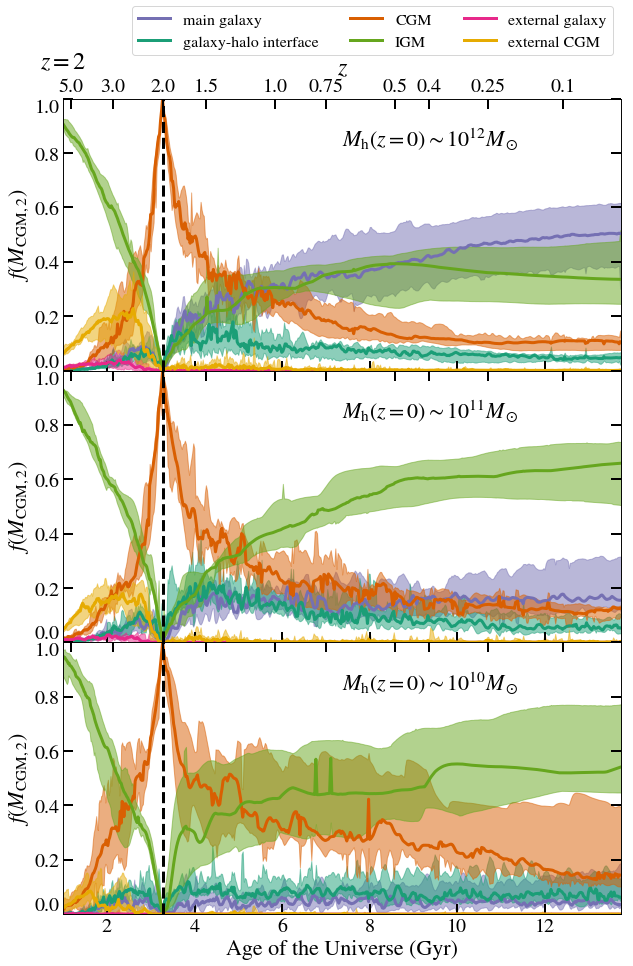

In [23]:
mass_bins = [ 'm12', 'm11', 'm10' ]
n_rows = len( mass_bins )

fig = plt.figure( figsize=(10,n_rows*5), facecolor='white' )
main_ax = plt.gca()

gs = gridspec.GridSpec( n_rows, 1 )

gs.update(wspace=0.025, hspace=0.0001)

for j, mass_bin in enumerate( mass_bins ):
    
    ax = plt.subplot(gs[j,0])
    
    mass_in_region_bin = mass_in_region.transpose().split_by_dict( linefinder_config.MASS_BINS )[mass_bin].transpose()
    
    for region in regions:

        ax.plot(
            time,
            np.nanpercentile( mass_in_region_bin[region].array(), 50, axis=0 ),
            linewidth = 3,
            color = p_constants.CLASSIFICATION_COLORS_B[region],
            label = p_constants.CLASSIFICATION_LABELS[region],
        )

        ax.fill_between(
            time,
            np.nanpercentile( mass_in_region_bin[region].array(), 16, axis=0 ),
            np.nanpercentile( mass_in_region_bin[region].array(), 84, axis=0 ),
            color = p_constants.CLASSIFICATION_COLORS_B[region],
            alpha = 0.5,
        )
        
        # Labels
        ax.set_xlabel( r'Age of the Universe (Gyr)', fontsize=22 )
        ax.set_ylabel( r"$f(M_{\rm CGM, " + '{:.02g}'.format( redshift ) + "})$", fontsize=22, )
        
    
    # Hide some axis labels
    if not ax.is_last_row():
        ax.tick_params( labelbottom = False )
            
    # Plot label
    if ax.is_first_row():
        ax.annotate(
            s = r'$z=' + '{:.02g}'.format( redshift ) + '$',
            xy = ( 0.0, 1.0 ),
            xytext = ( 0., 25., ),
            xycoords = 'axes fraction',
            textcoords = 'offset points',
            horizontalalignment = 'center',
            verticalalignment = 'bottom',
            fontsize = 24,
        )
    # Bin labels
    bin_label_mapping = {
        465: (0.025, 0.5),
        172: (0.5, 0.9 ),
    }
    ax.annotate(
        s = r'$M_{\rm h}(z=0) \sim 10^{' + mass_bin[1:] + r'} M_\odot$',
        xy = bin_label_mapping[snum],
        xycoords = 'axes fraction',
        horizontalalignment = 'left',
        verticalalignment = 'top',
        fontsize = 22, 
    )
    
    ax.set_xlim( 1, time.max() )
    ax.set_ylim( 0, 1 )

    # Avoid overlapping ticks
    ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
    ax.get_yticklabels()[-1].set_verticalalignment( 'top' )

    # Adjust tick parameters
    ax.tick_params( direction='in', which='both', top=False, right=True )

    if ax.is_first_row():
        ax.legend(
            prop = { 'size': 16 },
            loc = 'lower right',
            bbox_to_anchor = ( 1., 1.13 ),
            ncol = 3,
        )
    
    ax.axvline(
        x = time[ind],
        linewidth = 3,
        color = 'k',
        linestyle = '--',
    )
        
    # Add redshift to the axis
    tick_redshifts = np.array([ 0.1, 0.25, 0.4, 0.5, 0.75, 1, 1.5, 2, 3, 5, ])
    tick_times = []
    for z in tick_redshifts:
        tick_times.append( time[np.argmin(np.abs(w.get_data('redshift')-z))] )
    ax2 = plotting.add_redshift_to_axis(
        ax,
        hubble = w.ptracks.data_attrs['hubble'],
        omega_matter = w.ptracks.data_attrs['omega_matter'],
        tick_redshifts = tick_redshifts,
        tick_times = tick_times,
    )
    ax2.tick_params( direction='in' )
    # X label
    if ax.is_first_row():
        ax2.set_xlabel( r'$z$', fontsize=24 )
        
    if not ax.is_first_row():
        ax2.tick_params( labeltop = False )
        
    ax2.set_xlim( 1, time.max() )

# Save the File
save_file = 'location_of_CGM_gas_snum{}.pdf'.format( snum )
plotting.save_fig(
    out_dir = file_manager.get_project_figure_dir(),
    save_file = save_file,
    fig = fig,
)
fig

# Presentation Plot

In [24]:
mass_bins = [ 'm12', ]
n_rows = len( mass_bins )

plt.style.use('dark_background')

fig = plt.figure( figsize=(10,n_rows*5), facecolor='white' )
main_ax = plt.gca()

gs = gridspec.GridSpec( n_rows, 1 )

gs.update(wspace=0.025, hspace=0.0001)

for j, mass_bin in enumerate( mass_bins ):
    
    ax = plt.subplot(gs[j,0])

   # Hide some axis labels
    if not ax.is_last_row():
        ax.tick_params( labelbottom = False )
    if ax.is_first_row():
        ax.tick_params( labeltop = True )
            
    # Plot label
    if ax.is_first_row():
        ax.annotate(
            s = r'$z=' + '{:.02g}'.format( w.redshift[snum] ) + '$',
            xy = ( 0.0, 1.0 ),
            xytext = ( 0., 25., ),
            xycoords = 'axes fraction',
            textcoords = 'offset points',
            horizontalalignment = 'center',
            verticalalignment = 'bottom',
            fontsize = 24,
        )
    # Bin labels
    bin_label_mapping = {
        465: (0.025, 0.5),
        172: (0.5, 0.9 ),
    }
    ax.annotate(
        s = r'$M_{\rm h}(z=0) \sim 10^{' + mass_bin[1:] + r'} M_\odot$',
        xy = bin_label_mapping[snum],
        xycoords = 'axes fraction',
        horizontalalignment = 'left',
        verticalalignment = 'top',
        fontsize = 22, 
    )
    
    ax.set_xlim( 1, time.max() )
    ax.set_ylim( 0, 1 )

    # Avoid overlapping ticks
    ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
    ax.get_yticklabels()[-1].set_verticalalignment( 'top' )

    # Adjust tick parameters
    ax.tick_params( direction='in', which='both', top=True, right=True )
    
    ax.axvline(
        x = time[ind],
        linewidth = 3,
        color = 'w',
        linestyle = '--',
    )
    
    mass_in_region_bin = mass_in_region.split_by_dict( linefinder_config.MASS_BINS )[mass_bin].transpose()
    
    for k, region in enumerate( [ 'is_in_CGM', 'is_in_main_gal', 'is_in_IGM', 'is_in_galaxy_halo_interface', ] ):
        
        if region == 'is_in_other_gal':
            continue

        ax.plot(
            time,
            np.nanpercentile( mass_in_region_bin[region].array(), 50, axis=0 ),
            linewidth = 3,
            color = color_mapping[region],
            label = label_mapping[region],
        )

        ax.fill_between(
            time,
            np.nanpercentile( mass_in_region_bin[region].array(), 16, axis=0 ),
            np.nanpercentile( mass_in_region_bin[region].array(), 84, axis=0 ),
            color = color_mapping[region],
            alpha = 0.5,
        )
        
            # Labels
        ax.set_xlabel( r'Age of the Universe (Gyr)', fontsize=22 )
        ax.set_ylabel( r"$f(M_{\rm CGM})$", fontsize=22, )
        
        if ax.is_first_row():
            ax.legend(
                prop = { 'size': 16 },
                loc = 'lower right',
                bbox_to_anchor = ( 1., 1.07 ),
                ncol = 3,
            )
        
        # Save the File
        save_file = 'location_of_CGM_gas_snum{}_v{}.pdf'.format( snum, k )
        plotting.save_fig(
            out_dir = file_manager.project_parameters['presentation_dir'],
            save_file = save_file,
            fig = fig,
        )

# Save the File
save_file = 'location_of_CGM_gas_snum{}.pdf'.format( snum )
plotting.save_fig(
    out_dir = file_manager.project_parameters['presentation_dir'],
    save_file = save_file,
    fig = fig,
)

KeyError: 'm12'

# Extract Data